# 0. Importing Necessary Libraries

In [14]:
import numpy as np
import pandas as pd
import random
from pandarallel import pandarallel # for parallel computations with pandas
import time
import os
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', rc={'axes.facecolor': '0.9', 'figure.figsize':(12,6)})

# 1. Transaction Data Simulator

For confidentiality reasons, it is hard to find data related to fraud detection problems, despite its importance. Therefore, I will use a transaction data simulator to generate data for this project. Please refer to the [recent book about ML for fraud detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) that introduces the simulator for more details. In the following, I will briefly explain the main ideas behind the transactions data generating process.

The following table describes the features that will be present in each transaction.

| Transaction Feature | Description |
|:-------------------:|:-----------:|
|TRANSACTION_ID | Unique identifier for the transaction.|
|TX_DATETIME | Date and time of the transaction. |
|CUSTOMER_ID | Unique identifier of the customer who made the transaction. |
|TERMINAL_ID | Unique identifier of the terminal from which the transaction was made. |
|TX_AMOUNT | The amount of the transaction. |
|TX_FRAUD | Indicator variable for frauds (0 - Legitimate; 1 - Fraud).|



The simulation process will have five main steps:

1. Generation of customers profiles: each customer has different spending habits based on individual properties.

2. Generation of terminal profiles: defines the geographical location of the terminal.

3. Association of customer profiles to terminals: assumes that customers can only make transactions in terminals within a radius *r* of their geographical locations. Adds a feature 'list_terminals' to each customer profile, containing a set of terminals that the customer can use.

4. Generation of transactions: generates transactions by the customer profiles.

5. Generation of fraud scenarios: uses three different approaches to label some transactions as fraudulent.

## 1.1. Customer profiles generation

The customers will be modelled by the following attributes:

- CUSTOMER_ID: unique identifier of the customer.

- (x_customer, y_customer): pair of real coordinates in a 100 x 100 grid that defines the geographical location of the customer.

- (mean_amount, std_amount): mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.

- mean_nb_tx_per_day: The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4).

In [2]:
def generate_customer_profiles_table(n_customers, random_state=42):
    """
    Generates a table of customer profiles.
    
    Each customer profile consists of the folowing properties:
    * CUSTOMER_ID: unique identifier of the customer.
    * (x_customer, y_customer): pair of real coordinates in a 100 x 100 grid that defines the geographical location
    of the customer.
    * (mean_amount, std_amount): mean and standard deviation of the transaction amounts for the customer, assuming
    that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform
    distribution (5,100) and the std_amount will be set as the mean_amount divided by two.
    * mean_nb_tx_per_day: The average number of transactions per day for the customer, assuming that the number of
    transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4).
    
    Parameters
    ----------
    n_customers: int
        Number of customers for which to generate a profile
    random_state: int
        Random state for reproducibility of the results.
    
    Returns
    -------
    customer_profiles_table: pandas.DataFrame
        Table containing the properties of each customer.
        
    """
    # Setting up
    np.random.seed(random_state)
    MAX_COORDINATE = 100
    MIN_MEAN_AMOUNT = 5
    MAX_MEAN_AMOUNT = 100
    MAX_MEAN_NB_TX_PER_DAY = 4
    
    # Generate customer profiles
    customers_properties = []
    for customer_id in range(n_customers):
        x_customer = np.random.uniform(0, MAX_COORDINATE)
        y_customer = np.random.uniform(0, MAX_COORDINATE)
        mean_amount = np.random.uniform(MIN_MEAN_AMOUNT, MAX_MEAN_AMOUNT)
        std_amount = mean_amount / 2
        mean_nb_tx_per_day = np.random.uniform(0, MAX_MEAN_NB_TX_PER_DAY)
        customers_properties.append([
            customer_id,
            x_customer, y_customer,
            mean_amount, std_amount,
            mean_nb_tx_per_day
        ])
    customer_profiles_table = pd.DataFrame(customers_properties, columns=['CUSTOMER_ID',
                                                                         'x_customer', 'y_customer',
                                                                         'mean_amount', 'std_amount',
                                                                         'mean_nb_tx_per_day'])
    return customer_profiles_table 

## 1.2. Terminal profiles generation

The terminals will be modelled by the following attributes:

- TERMINAL_ID: unique identifier of the terminal.

- (x_terminal, y_terminal): pair of real coordinates in a 100 x 100 grid that defines the geographical location of the temrinal.

In [3]:
def generate_terminal_profiles_table(n_terminals, random_state=42):
    """
    Generates a table of terminal profiles.
    
    Each terminal profile consists of the folowing properties:
    * TERMINAL_ID: unique identifier of the terminal.
    * (x_temrinal, y_temrinal): pair of real coordinates in a 100 x 100 grid that defines the geographical location
    of the terminal.
    
    Parameters
    ----------
    n_terminals: int
        Number of terminals for which to generate a profile
    random_state: int
        Random state for reproducibility of the results.
    
    Returns
    -------
    terminal_profiles_table: pandas.DataFrame
        Table containing the properties of each terminal.
        
    """
    # Setting up
    np.random.seed(random_state)
    MAX_COORDINATE = 100

    # Generate terminal profiles
    terminals_properties = []
    for terminal_id in range(n_terminals):
        x_terminal = np.random.uniform(0, MAX_COORDINATE)
        y_terminal = np.random.uniform(0, MAX_COORDINATE)
        terminals_properties.append([
            terminal_id,
            x_terminal, y_terminal,
        ])
    terminal_profiles_table = pd.DataFrame(terminals_properties, columns=['TERMINAL_ID',
                                                                         'x_terminal', 'y_terminal',
                                                                         ])
    return terminal_profiles_table 

## 1.3. Association of customer profiles to terminals

In [4]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    """
    Generates the list of all terminals within a radius 'r' of the customer.
    
    The simulation assumes that customers can only make transactions in terminals within a radius r of their
    geographical locations, which adds a feature 'list_terminals' to each customer profile, containing a set of
    terminals that the customer can use.
    
    Parameters
    ----------
    customer_profile: pandas.Series
        The profile of a customer (a row from customer_profiles_table).
    x_y_terminals: numpy.ndarray
        An array that contains the geographical locations of all terminals.
    r: float
        Radius around the customer location to determine terminal availability.
    
    Returns
    -------
    list_terminals: list
        List of the IDs of the terminals available to the customer.
        
    """
    # Location of the customer
    x_y_customer = customer_profile[['x_customer', 'y_customer']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute sqrt to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    list_terminals = list(np.where(dist_x_y < r)[0])

    return list_terminals

## 1.4. Generation of transactions

The customers' properties regulate transaction features such as frequency and typical amounts. Besides this, the simulations will try to reflect that most transactions occur during the day. Therefore, the transaction times, in seconds along a day, will follow a normal distribution centered around noon with an std of 20000 seconds. 

In [5]:
def generate_transactions_table(customer_profile, start_date='2022-01-01', nb_days=200):
    """
    Generates a table of unlabeled transactions by a customer profile.
    
    The customer's properties regulate transaction features such as frequency and typical amounts. The transaction
    times, in seconds along a day, will follow a normal distribution centered around noon with an std of 20000 
    seconds. 
    
    Parameters
    ----------
    customer_profile: pandas.Series
        The profile of a customer (a row from customer_profiles_table).
    start_date: str
        The date of the first transaction in the format "YYYY-MM-DD".
    nb_days: int
        The number of days to generate transactions.
        
    Returns
    -------
    customer_transactions: pandas.DataFrame
        Table with transactions made by the customer over the specified period.

    """
    # Setting up
    customer_transactions = []
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    TOTAL_SECONDS_DAY = 86400
    MEAN_TX_TIME = TOTAL_SECONDS_DAY / 2 # corresponding to noon
    STD_TX_TIME = 20000
    
    
    for day in range(nb_days):
        # number of transactions for this day
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # if customer did some transactions, generate them
        if nb_tx > 0: 
            for tx in range(nb_tx):
                # time of the transaction, in seconds of that day.
                tx_time = int(np.random.normal(MEAN_TX_TIME, STD_TX_TIME))
                # if transacton time is in the (0, TOTAL_SECONDS_DAY) interval, accept it
                if 0 < tx_time and tx_time < TOTAL_SECONDS_DAY:
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    # if amount is negative, draw from a uniform disribution
                    if amount < 0:
                        amount = np.random.uniform(0, customer_profile.mean_amount * 2)
                    else:
                        pass
                    amount = np.round(amount, decimals=2)
                    # verify terminal availability
                    if len(customer_profile.list_terminals) > 0:
                        terminal_id = random.choice(customer_profile.list_terminals)
                        customer_transactions.append([
                            tx_time + day * TOTAL_SECONDS_DAY, day,
                            customer_profile.CUSTOMER_ID,
                            terminal_id, amount
                        ])
                    else:
                        continue
                else: 
                    continue
        else:
            continue
    customer_transactions = pd.DataFrame(customer_transactions, columns=[
        'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 
    ])
    
    if len(customer_transactions) > 0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions['TX_TIME_SECONDS'], 
                                                             unit='s',
                                                             origin=start_date)
        customer_transactions = customer_transactions[[
            'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS'
        ]]
    else:
        pass
    
    return customer_transactions

At this point, it is possible to generate a dataset of unlabeled transactions.

In [6]:
def generate_dataset(n_customers=5000, n_terminals=10000, nb_days=200, start_date='2022-01-01', r=5):
    '''
    Generates an unlabeled dataset of transactions and displays relevant timing information.
    
    Each unlabeled transaction has the following features:
    * TRANSACTION_ID: unique identifier for the transaction.
    * TX_DATETIME: date and time of the transaction.
    * CUSTOMER_ID: the unique identifier of the customer who made the transaction. 
    * TERMINAL_ID: the unique identifier of the terminal associated with the transaction. 
    * TX_AMOUNT: the amount of the transaction.
    * TX_SECONDS: the number of elapsed seconds since the date of the first recorded transaction.
    * TX_DAYS: the number of elapsed days since the date of the first recorded transaction.

    
    Parameters
    ----------
    n_customers: int
        The number of customers of the institution.
    n_terminals: int
        The number of terminals with support of the institution.
    nb_days: int
        The number of days to generate transactions.
    start_date: str
        The date of the first transaction in the format "YYYY-MM-DD".
    r: float
        The radius (distance) 'r' determines the terminals available to each customer.
        
    Returns
    -------
    customer_profiles_table: pandas.DataFrame
        Table with the properties of each customer.
    terminal_profiles_table: pandas.DataFrame
        Table with the properties of each terminal.
    transactions_df: pandas.DataFrame
        Table with all transactions of the simulation.
    
    '''
    # set up pandarallel to enable parallel_apply pandas methods
    pandarallel.initialize(use_memory_fs=False)

    # Generate customer profiles
    start_time = time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers)
    print(f'Time to generate customer profiles table: {time.time() - start_time:.2f}s.')
    
    # Generate terminal profiles
    start_time = time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals)
    print(f'Time to generate terminal profiles table: {time.time() - start_time:.2f}s.')
    
    # Associate terminals to customers
    start_time = time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal', 'y_terminal']].values.astype(float)
    customer_profiles_table['list_terminals'] = customer_profiles_table.parallel_apply(
        lambda x: get_list_terminals_within_radius(x, x_y_terminals, r), axis=1
    )
    print(f'Time to associate terminals to customers: {time.time() - start_time:.2f}s.')
    
    
    # Generate transactions
    start_time = time.time()
    transactions_df = customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(
        lambda x: generate_transactions_table(x.iloc[0], start_date, nb_days),
    ).reset_index(drop=True)
    print(f'Time to generate transactions: {time.time() - start_time:.2f}s.')
    
    # Sort transactions chronologically
    transactions_df = transactions_df.sort_values('TX_DATETIME')
    
    # Reset indexes
    transactions_df.reset_index(inplace=True, drop=True)
    
    # TRANSACTION_ID are the dataframe indices, startng from 0
    transactions_df.reset_index(inplace=True)
    transactions_df.rename(columns={'index':'TRANSACTION_ID'}, inplace=True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [7]:
customer_profiles_table, terminal_profiles_table, transactions_df = generate_dataset()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Time to generate customer profiles table: 0.21s.
Time to generate terminal profiles table: 0.21s.
Time to associate terminals to customers: 9.21s.
Time to generate transactions: 227.76s.


## 1.5. Fraud scenarios generation

Finally, the simulation adds fraud labels to the transactions by the following scenarios:

1. Any transaction of more than 220 is fraud. This scenario intends to validate the implementation of any fraud detection system, as any system should be able to discern such an obvious pattern.

2. Every day, randomly select two terminals and assign any transactions from these terminals as fraudulent for the next 28 days. This scenario simulates known criminal tactics such as phishing.

3. Every day, randomly select three customers. In the next 14 days, select 1/3 of their transactions, multiply the amounts by five and mark them as fraudulent. This scenario simulates customer credentials leakage. The customer continues to make transactions within his spending habits. Meanwhile, the fraudster tries to maximize his gains by making sporadic transactions of large amounts.

In [10]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    '''
    Adds fraud labels to a dataset of transactions and displays relevant statistics.
    
    The labels follow three different fraud scenarios:
    1 -> Any transaction of more than 220 is fraud. This scenario intends to validate the implementation of any fraud
    detection system, as any system should be able to discern such an obvious pattern.
    2 -> Every day, randomly select two terminals and assign any transactions from these terminals as fraudulent for
    the next 28 days. This scenario simulates known criminal tactics such as phishing.
    3 -> Every day, randomly select three customers. In the next 14 days, select 1/3 of their transactions, multiply 
    the amounts by five and mark them as fraudulent. This scenario simulates customer credentials leakage. The 
    customer continues to make transactions within his spending habits. Meanwhile, the fraudster tries to maximize 
    his gains by making sporadic transactions of large amounts.
    
    Parameters
    ----------
    customer_profiles_table: pandas.DataFrame
        Table with the properties of each customer.
    terminal_profiles_table: pandas.DataFrame
        Table with the properties of each terminal.
    transactions_df: pandas.DataFrame
        Table with all transactions of the simulation.
        
    Returns
    -------
    labeled_transactions_df: pandas.DataFrame
        Table of all transactions with the corresponding fraud labels and scenarios.
    
    '''
    # Set up
    labeled_transactions_df = transactions_df.copy()
    AMOUNT_THRESHOLD = 220
    COMPROMISED_TERMINALS_PER_DAY = 2
    COMPROMISE_PERIOD_DAYS = 28
    LEAKED_CREDENTIALS_PER_DAY = 3
    LEAKAGE_PERIOD_DAYS = 14
    FRAUD_FRACTION = 1 / 3
    FRAUD_AMOUNT_FACTOR = 5
    
    
    # By default, all transactions are genuine
    labeled_transactions_df['TX_FRAUD'] = 0
    labeled_transactions_df['TX_FRAUD_SCENARIO'] = 0 #
    
    # Scenario 1
    labeled_transactions_df.loc[labeled_transactions_df.TX_AMOUNT > AMOUNT_THRESHOLD, 'TX_FRAUD'] = 1
    labeled_transactions_df.loc[labeled_transactions_df.TX_AMOUNT > AMOUNT_THRESHOLD, 'TX_FRAUD_SCENARIO'] = 1
    nb_frauds_scenario_1 = labeled_transactions_df.TX_FRAUD.sum()
    print(f'Number of frauds from scenario 1: {nb_frauds_scenario_1}')
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        comprimised_terminals = terminal_profiles_table.TERMINAL_ID.sample(
            n=COMPROMISED_TERMINALS_PER_DAY, random_state=day
        )
        compromised_transactions = transactions_df[
            (transactions_df.TX_TIME_DAYS >= day) &
            (transactions_df.TX_TIME_DAYS < day + COMPROMISE_PERIOD_DAYS) &
            (transactions_df.TERMINAL_ID.isin(comprimised_terminals))
        ]
        labeled_transactions_df.loc[compromised_transactions.index, 'TX_FRAUD'] = 1
        labeled_transactions_df.loc[compromised_transactions.index, 'TX_FRAUD_SCENARIO'] = 2
    nb_frauds_scenario_2 = labeled_transactions_df.TX_FRAUD.sum() - nb_frauds_scenario_1
    print(f'Number of frauds from scenario 2: {nb_frauds_scenario_2}')
    
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        comprimised_customers = customer_profiles_table.CUSTOMER_ID.sample(
            n=LEAKED_CREDENTIALS_PER_DAY, random_state=day
        ).values
        compromised_transactions = transactions_df[
            (transactions_df.TX_TIME_DAYS >= day) &
            (transactions_df.TX_TIME_DAYS < day + LEAKAGE_PERIOD_DAYS) &
            (transactions_df.CUSTOMER_ID.isin(comprimised_customers))
        ]
        nb_compromised_transactions = len(compromised_transactions)
        
        # select 1/3 of transactions and make them fraudulent
        random.seed(day)
        index_frauds = random.sample(
            list(compromised_transactions.index.values), k=int(nb_compromised_transactions * FRAUD_FRACTION)
        )
        labeled_transactions_df.loc[index_frauds, 'TX_AMOUNT'] *= FRAUD_AMOUNT_FACTOR
        labeled_transactions_df.loc[index_frauds, 'TX_FRAUD'] = 1
        labeled_transactions_df.loc[index_frauds, 'TX_FRAUD_SCENARIO'] = 3
    nb_frauds_scenario_3 = labeled_transactions_df.TX_FRAUD.sum() - nb_frauds_scenario_2 - nb_frauds_scenario_1
    print(f'Number of frauds from scenario 3: {nb_frauds_scenario_3}')

    return labeled_transactions_df

In [11]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 1055
Number of frauds from scenario 2: 10276
Number of frauds from scenario 3: 5097
CPU times: user 5min 2s, sys: 226 ms, total: 5min 2s
Wall time: 5min 2s


## 1.6. Saving of dataset

The dataset is saved in daily batches to allow further control when loading data from specific periods. The pickle format is chosen over CSV to speed up loading times.

In [38]:
def save_to_files(dir_output, transactions_df, start_date):
    '''
    Saves a table of transactions to pickle files in daily batches.
    
    The pickle files are named 'YYYY-MM-DD.pkl' into the directory 'dir_output'. The 'start_date' defines the date
    of the first transaction, and subsequent transactions are saved based on the number of seconds elapsed since
    day one.
    
    Parameters
    ----------
    dir_output: str
        A string containing the path of the directory that will store the files.
    transactions_df: pandas.DataFrame
        A table containing the transactions to save.
    start_date: str
        A string containing the date assigned to the first transaction in the table, in the form 'YYYY-MM-DD'.
    
    Returns
    -------
        None
    
    '''
    if not os.path.exists(dir_output):
        os.makedirs(dir_output)
    else:
        pass
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    for day in range(transactions_df.TX_TIME_DAYS.max() + 1):
        transactions_day = transactions_df[transactions_df.TX_TIME_DAYS == day].sort_values('TX_TIME_SECONDS')
        date = start_date + timedelta(days=day)
        filename_output = date.strftime('%Y-%m-%d') + '.pkl'
        # Protocol = 4 required by Google Colab
        transactions_day.to_pickle(DIR_OUTPUT + filename_output, protocol=4)

In [15]:
# Save simulated transactions
save_to_files('./simulated_data_raw/', transactions_df, '2022-01-01')

# 2. Exploratory Data Analysis and Feature Engineering

## 2.1. Loading the data

In [2]:
def read_from_files(dir_input, begin_date, end_date):
    '''
    Loads a set of transaction files into a single DataFrame and orders it by transaction time.
    
    The transaction files are pickle files in 'dir_input', with the file names in the format 'YYYY-MM-DD.pkl'. This 
    way, the parameters begin_date and end_date control which files are loaded.
    
    Parameters
    ----------
    dir_input: str
        A string containing the path of the directory that stores the files.
    begin_date: str
        A string containing the first day of transactions to load, in the form 'YYYY-MM-DD'.
    end_date: str
        A string containing the last day of transactions to load, in the form 'YYYY-MM-DD'.
        
    Returns
    -------
    transactions_df: pandas.DataFrame
        A table with all requested transactions.
    
    '''
    files = [os.path.join(dir_input, file) 
             for file in os.listdir(dir_input) if file >= begin_date+'.pkl' and file <= end_date+'.pkl']
    data_frames = []
    for file in files:
        data_frame = pd.read_pickle(file)
        data_frames.append(data_frame)
        del data_frame
    transactions_df = pd.concat(data_frames)
    transactions_df = transactions_df.sort_values('TX_DATETIME')
    transactions_df.reset_index(drop=True,inplace=True)
    return transactions_df

In [3]:
# loading transactions from the first semester of 2022
transactions_df = read_from_files('./simulated_data_raw/', '2022-01-01', '2022-06-30')

## 2.2. Exploring the data

In [7]:
# visualize number of transactions and features
transactions_df.shape

(1758005, 9)

In [8]:
# inspecting a few instances
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2022-01-01 00:00:31,1829,4083,22.35,31,0,0,0
1,1,2022-01-01 00:01:59,157,3553,9.53,119,0,0,0
2,2,2022-01-01 00:02:29,834,4124,82.26,149,0,0,0
3,3,2022-01-01 00:04:47,2845,6957,25.29,287,0,0,0
4,4,2022-01-01 00:07:04,1565,8020,31.69,424,0,0,0


In [19]:
# getting general information about the data
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758005 entries, 0 to 1758004
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.7+ MB


In [22]:
# checking for missing values
transactions_df.isnull().sum()

TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [4]:
# convert data to appropriate types
transactions_df.TRANSACTION_ID = transactions_df.TRANSACTION_ID.astype(str)
transactions_df.TX_TIME_DAYS = transactions_df.TX_TIME_DAYS.astype(int)
transactions_df.TX_TIME_SECONDS = transactions_df.TX_TIME_SECONDS.astype(int)

In [13]:
# exploring distribution of the response variable: 'tx_fraud'
transactions_df.TX_FRAUD.value_counts()

0    1743230
1      14775
Name: TX_FRAUD, dtype: int64

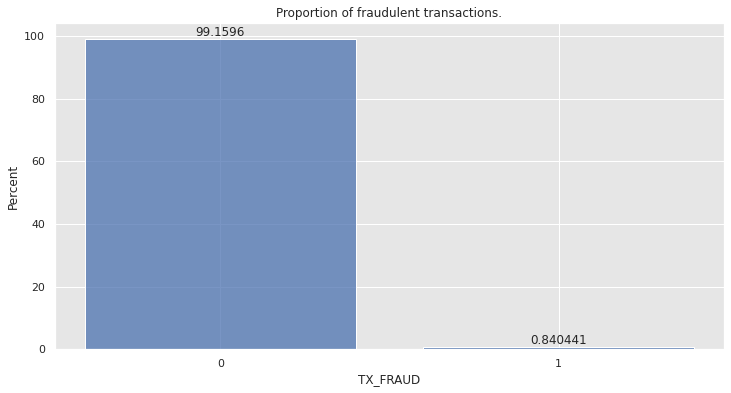

In [15]:
# visualize proportion of fraudulent transactions
ax = sns.histplot(x='TX_FRAUD', data=transactions_df, stat='percent', discrete=True, shrink=0.8, )
ax.bar_label(ax.containers[0])
ax.set_xticks([0, 1])
plt.title('Proportion of fraudulent transactions.')
plt.show()

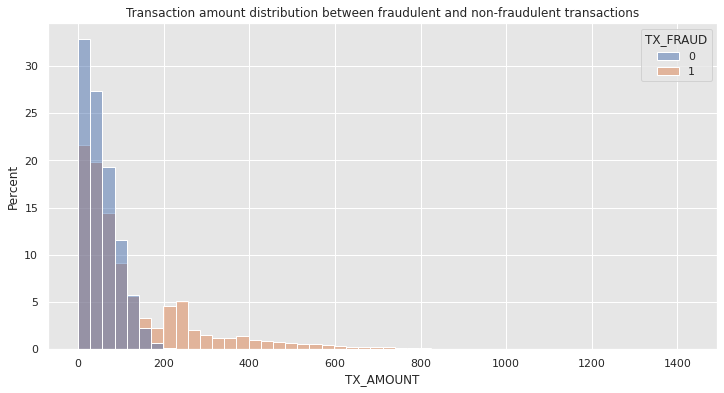

In [16]:
# visualize relation between transaction amounts and frauds
ax = sns.histplot(x='TX_AMOUNT', hue='TX_FRAUD', data=transactions_df, stat='percent', bins=50, common_norm=False)
ax.set_title('Transaction amount distribution between fraudulent and non-fraudulent transactions');

At this stage of the EDA,  we can identify the fraud pattern associated with transactions above 200 monetary units.

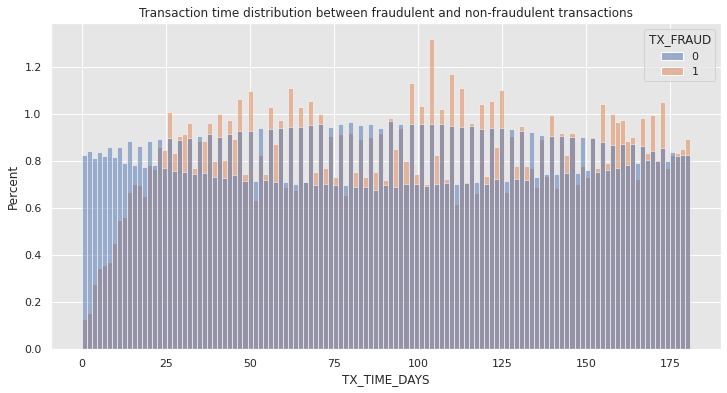

In [17]:
# visualize relationship between transaction times and frauds
SECONDS_IN_A_DAY = 86400
time_plot_df = transactions_df.loc[:, ['TX_TIME_SECONDS', 'TX_FRAUD']].copy() # aux df for this vizualization
time_plot_df['TX_TIME_DAYS'] = time_plot_df.TX_TIME_SECONDS / SECONDS_IN_A_DAY
ax = sns.histplot(x='TX_TIME_DAYS', hue='TX_FRAUD', data=time_plot_df, stat='percent', common_norm=False)
ax.set_title('Transaction time distribution between fraudulent and non-fraudulent transactions');

One can note periodic increases in fraudulent activity over the six months, consistent with known fraudster patterns like phishing and credential leakage. 

The following function facilitates future integration of the transactions data: 

In [21]:
def set_appropriate_dtypes(transactions_df):
    '''
    Set appropriate data types for the transactions data.
    
    This is for convenient use of fixed transactions data in an environment such as a notebook.
    
    Parameters
    ----------
    transactions_df: pandas.DataFrame
        A table with transactions.
        
    Returns
    -------
    transactions_df_clean: pandas.DataFrame
        A table of the original transactions with all features in appropriate data types.
    
    '''
    #return variable
    transactions_df_clean = transactions_df.copy()
    
    transactions_df_clean.TRANSACTION_ID = transactions_df_clean.TRANSACTION_ID.astype(str)
    transactions_df_clean.TX_TIME_DAYS = transactions_df_clean.TX_TIME_DAYS.astype(int)
    transactions_df_clean.TX_TIME_SECONDS = transactions_df_clean.TX_TIME_SECONDS.astype(int)
    
    return transactions_df_clean

## 2.3. Feature Engineering

One of the most relevant stages of a data science project is feature engineering, where we leverage the potential information in the data with domain knowledge to maximize the business value generated by ML models.

In the context of credit card fraud detection, experience shows that some determinant features to look for are:
- Relevant periods: day or night, weekdays or weekends.
- Customer spending habits: the typical amount and number of transactions of each customer.
- Terminal risk: a measure of how many fraudulent transactions have occurred in each terminal.

These points justify the introduciton of the following features:

- TX_DURING_WEEKEND: characterizes whether a transaction occurs during weekends (1) or weekdays (0).
- TX_DURING_NIGHT: characterizes whether a transaction occurs during the night. **In this context, the night is the period from 0 pm to 6 am**.
- NB_TX_{n}DAY_WINDOW_CUST (n=1, 7, 30): the number of transactions of a customer in the last 1, 7 or 30 days.
- AVG_AMOUNT_{n}DAY_WINDOW (n=1, 7, 30): the average transaction amount of a customer in the last 1, 7 or 30 days.
- NB_TX_{n}DAY_WINDOW_TERM (n=1, 7, 30): the number of transactions on a terminal in the last n + d days, for n = 1, 7 or 30 and d = 7. The parameter d is called *delay*.
- RISK_{n}DAY_WINDOW (n=1, 7, 30): the average number of frauds on a terminal in the last n+ d days, for n = 1, 7 or 30 days and d = 7.

The sizes of the time windows and the delay period are sensible values based on known fraud patterns. Later, they might become hyperparameters of an ML model and adjusted to specific needs, such as concept drift. 

The delay period accounts for the time difference between a fraud occurrence and its acknowledgment after an investigation or customer complaint.

The following functions facilitate the implementation of the above features:

In [18]:
def add_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1, 7, 30]):
    '''
    Adds the number of transactions and average amount over the given time windows.
    
    Computes the customer spending habits, such frequency and the average amount of transactions, from a table of 
    'customer_transactions' for each time window in the list 'windows_size_in_days'.
    
    Parameters
    ----------
    customer_transactions: pandas.DataFrame
        A table with the transactions of a given customer.
    windows_size_in_days: list
        A list of positive integers with the sizes of the time windows.
    
    Returns
    -------
    customer_transactions_agg: pandas.DataFrame
        A table with the customer transactions containing the computed aggregate features.
    
    '''
    # First, order transactions chronologically and set it as the index, to allow the use of the rolling function.
    customer_transactions_agg = customer_transactions.sort_values('TX_DATETIME').copy()
    customer_transactions_agg.index = customer_transactions_agg.TX_DATETIME
    
    for window_size in windows_size_in_days:
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW = customer_transactions_agg['TX_AMOUNT'].rolling(str(window_size) + 'd').sum()
        NB_TX_WINDOW = customer_transactions_agg['TX_AMOUNT'].rolling(str(window_size) + 'd').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW = SUM_AMOUNT_TX_WINDOW / NB_TX_WINDOW
    
        # Save feature values
        customer_transactions_agg['NB_TX_' + str(window_size) +'DAY_WINDOW_CUST'] = list(NB_TX_WINDOW)
        customer_transactions_agg['AVG_AMOUNT_' + str(window_size) + 'DAY_WINDOW'] = list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions_agg.index = customer_transactions_agg.TRANSACTION_ID
        
    return customer_transactions_agg

In [19]:
def add_terminal_risk_profile(terminal_transactions, windows_size_in_days=[1, 7, 30], delay_period=7):
    '''
    Adds the number of transactions and risk factors over the given time windows.
    
    Computes the terminal risk characteristics, such as frequency and average number of frauds (risk), from a table
    of 'terminal_transactions' for each time window in the list 'windows_size_in_days'. The delay period accounts 
    for the time difference between a fraud occurrence and its acknowledgment after an investigation or customer 
    complaint.
    
    Parameters
    ----------
    terminal_transactions: pandas.DataFrame
        A table with the transactions on a given terminal.
    windows_size_in_days: list
        A list of positive integers with the sizes of the time windows.
    delay_period: int
        The days between the occurence and acknowledgment of fraudulent activity.
    
    Returns
    -------
    terminal_transactions_agg: pandas.DataFrame
        A table with the terminal transactions containing the computed aggregate features.
    
    '''
    # First, order transactions chronologically and set it as the index, to allow the use of the rolling function.
    terminal_transactions_agg = terminal_transactions.sort_values('TX_DATETIME').copy()
    terminal_transactions_agg.index = terminal_transactions_agg.TX_DATETIME
    
    # One is insterested in the number of frauds over a time window only, but one has to wait for the delay
    # period, otherwise the fraud would still be unnoticed.
    
    # number of frauds in the delay period after each transaction.
    NB_FRAUD_DELAY = terminal_transactions_agg['TX_FRAUD'].rolling(str(delay_period) + 'd').sum()
    # number of transactions in the delay period after each transaction.
    NB_TX_DELAY = terminal_transactions_agg['TX_FRAUD'].rolling(str(delay_period) + 'd').count()
    
    for window_size in windows_size_in_days:
        # number of frauds in the delay period + window size after each transaction.
        NB_FRAUD_DELAY_WINDOW = terminal_transactions_agg['TX_FRAUD'].rolling(str(delay_period+window_size) + 'd'
                                                                           ).sum()
        # number of transactions in the delay period + window size after each transaction.
        NB_TX_DELAY_WINDOW = terminal_transactions_agg['TX_FRAUD'].rolling(str(delay_period + window_size) + 'd'
                                                                          ).count()
        NB_FRAUD_WINDOW = NB_FRAUD_DELAY_WINDOW - NB_FRAUD_DELAY
        NB_TX_WINDOW = NB_TX_DELAY_WINDOW - NB_TX_DELAY
        RISK_WINDOW = NB_FRAUD_WINDOW / NB_TX_WINDOW # proportion of frauds over the time window
        
        terminal_transactions_agg['NB_TX_' + str(window_size) + 'DAY_WINDOW'] = list(NB_TX_WINDOW)
        terminal_transactions_agg['RISK_' + str(window_size) + 'DAY_WINDOW'] = list(RISK_WINDOW)
        
    terminal_transactions_agg.index = terminal_transactions_agg.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions_agg.fillna(0, inplace=True)
    
    return terminal_transactions_agg

In [20]:
def credit_card_fraud_feature_engineering(transactions_df):
    '''
    Engineers relevant features to the problem of credit card fraud detection.
    
    Given a table of transactions, computes features associated with customer behavior and terminal risk.
    
    Parameters
    ----------
    transactions_df: pandas.DataFrame
        A table with transactions.
    
    Returns
    -------
    transactions_df_eng: pandas.DataFrame
        A table of the original transactions with the addition of customer behavior and terminal risk features. 
    
    '''
    # return variable
    transactions_df_eng = transactions_df.copy()
    
    # datetime transformations
    transactions_df_eng['TX_DURING_WEEKEND'] = transactions_df.TX_DATETIME.apply(lambda x: int(x.weekday() >= 5))
    transactions_df_eng['TX_DURING_NIGHT'] = transactions_df.TX_DATETIME.apply(lambda x: int(x.hour < 6))
    
    # customer behavior transformations
    transactions_df_eng = transactions_df_eng.groupby('CUSTOMER_ID').apply(
        lambda x: add_customer_spending_behaviour_features(x)
    ).sort_values('TX_DATETIME').reset_index(drop=True)
    
    # terminal risk transformations
    transactions_df_eng = transactions_df_eng.groupby('TERMINAL_ID').apply(
        lambda x: add_terminal_risk_profile(x)
    ).sort_values('TX_DATETIME').reset_index(drop=True)
    
    return transactions_df_eng
    